In [1]:
import numpy as np
import math
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
import cartopy
import cartopy.crs as ccrs
import metpy.calc as mpcalc
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
import pop_tools 
import matplotlib.path as mpath
import dask
import utils
import pandas as pd
import copernicus_marine_client as copernicus_marine

import matplotlib.gridspec as gridspec
import matplotlib.colors as colors

# Including Glade CESM Data

## To dos:
- Pick a smaller timespan to subset on
- Figure out cloud storage locations for CESM dataset and COPEPOD dataset, if unable to access another way
- Add much more text describing motivation, some of the science

# Getting + processing CESM data

In [2]:
case = 'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.002branch'
path = '/glade/campaign/cesm/development/bgcwg/projects/CESM2-OMIP2-like-4p2z-run/'+case+'/ocn/proc/tseries/month_1'
variables = ['diatChl', 'coccoChl','spChl','diazChl','mesozooC']
coords = {'x':'TLONG','y':'TLAT'}
keep_vars = variables + list(coords.values())+['dz','KMT','time_bound']
path

'/glade/campaign/cesm/development/bgcwg/projects/CESM2-OMIP2-like-4p2z-run/g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.002branch/ocn/proc/tseries/month_1'

## Get monthly data and immediately convert it to annual

In [3]:
def preprocess(ds):
    #ds=ds.isel(z_t=0)
    ds=ds.isel(z_t_150m=0)
    return ds

In [4]:
def preprocess2(ds):
    #ds=ds.isel(z_t=0)
    ds=ds.mean(dim='z_t_150m')
    return ds

## Add some text explaining what's happening here

In [5]:
%%time

ds = xr.Dataset()


for v in variables:  
    print(v)
    files = sorted(glob(f'{path}/{case}.pop.h.{v}.195801-202112.nc'))

    if v=='mesozooC':
        print('got mesozoo, making avg')
        dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, 
                              combine='nested', concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True,preprocess=preprocess2)
    else:
        print('got a chl var, getting surf')
        dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, 
                              combine='nested', concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True,preprocess=preprocess)

    ### is this override setting correct?
    ds = xr.merge((ds, dsv), compat='override')

ds = ds.drop([v for v in ds.variables if v not in keep_vars]).squeeze()

diatChl
got a chl var, getting surf
coccoChl
got a chl var, getting surf
spChl
got a chl var, getting surf
diazChl
got a chl var, getting surf
mesozooC
got mesozoo, making avg
CPU times: user 958 ms, sys: 125 ms, total: 1.08 s
Wall time: 4.74 s


In [6]:
ds["time"] = ds.time_bound.compute().mean(dim="d2")

## Spin up some Dask to make the processing faster

This probably needs to be removed for the cookbook

In [7]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='25GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=25GB',
        project='NCGD0011',
        walltime='01:00:00',
        interface='ext',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

In [8]:
cluster, client = get_ClusterClient()
cluster.scale(8) 

In [9]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/eromashkova/proxy/45441/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/eromashkova/proxy/45441/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.94:39727,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/eromashkova/proxy/45441/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [10]:
ds_grid = pop_tools.get_grid('POP_gx1v7')

area = ds_grid.TAREA
lats = ds_grid.TLAT
lons = ds_grid.TLONG

## Processing the CESM output

### Make annual means

In [11]:
ds_ann = ds.resample({'time':'A'}).mean(dim='time').compute()

### Trim it to the same years as the hi res comparison: 1997 to 2021

In [12]:
ds_ann.time[39:64]

<xarray.DataArray 'time' (time: 25)>
array([cftime.DatetimeNoLeap(1997, 12, 31, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1998, 12, 31, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1999, 12, 31, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2000, 12, 31, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2001, 12, 31, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2002, 12, 31, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2003, 12, 31, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2004, 12, 31, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2005, 12, 31, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2006, 12, 31, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2007, 12, 31, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2008, 12, 31, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2009, 12, 31, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2010, 12, 31, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2011, 12, 31, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2012, 12, 31, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2013, 12, 31, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2014, 12, 31, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 12, 31, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2016, 12, 31, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2017, 12, 31, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2018, 12, 31, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2019, 12, 31, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2020, 12, 31, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2021, 12, 31, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 1997-12-31 00:00:00 ... 2021-12-31 00:00:00

In [13]:
ds_ann = ds_ann.isel(time=slice(39,64))

In [14]:
ds = ds_ann.mean(dim='time')

In [15]:
ds

<xarray.Dataset>
Dimensions:   (nlat: 384, nlon: 320, z_t: 60)
Coordinates:
    TLAT      (nlat, nlon) float64 -79.22 -79.22 -79.22 -79.22 ... nan nan nan
    TLONG     (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... nan nan nan nan
Dimensions without coordinates: nlat, nlon, z_t
Data variables:
    KMT       (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
    diatChl   (nlat, nlon) float32 nan nan nan nan nan ... nan nan nan nan nan
    dz        (z_t) float32 1e+03 1e+03 1e+03 ... 2.499e+04 2.5e+04 2.5e+04
    coccoChl  (nlat, nlon) float32 nan nan nan nan nan ... nan nan nan nan nan
    spChl     (nlat, nlon) float32 nan nan nan nan nan ... nan nan nan nan nan
    diazChl   (nlat, nlon) float32 nan nan nan nan nan ... nan nan nan nan nan
    mesozooC  (nlat, nlon) float32 nan nan nan nan nan ... nan nan nan nan nan

### Adding all the sources of chlorophyll in CESM's biogeochemistry model

In [16]:
cesm_chl = ds.diatChl + ds.spChl + ds.coccoChl + ds.diazChl

# Getting GlobColour chlorophyll concentration satellite data

In [17]:
### need to get a generic set of login credentials and provide a file to input those

ds_sat = copernicus_marine.open_dataset( 
    dataset_id = 'c3s_obs-oc_glo_bgc-plankton_my_l3-multi-4km_P1D',
    variables= ['CHL'],
    start_datetime = "2012-01-01",
    end_datetime = "2012-12-31",
)
ds_sat

INFO - 2024-01-04T20:53:36Z - Selected dataset version is "202303"
INFO - 2024-01-04T20:53:36Z - Selected dataset part is "default"
INFO - 2024-01-04T20:53:38Z - Selected service is "CopernicusMarineDatasetServiceType.GEOSERIES"
username:

  lromashkov


password:

  ········


<xarray.Dataset>
Dimensions:    (time: 366, latitude: 4320, longitude: 8640)
Coordinates:
  * latitude   (latitude) float64 -89.98 -89.94 -89.9 ... 89.9 89.94 89.98
  * longitude  (longitude) float64 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
  * time       (time) datetime64[ns] 2012-01-01 2012-01-02 ... 2012-12-31
Data variables:
    CHL        (time, latitude, longitude) float32 ...
Attributes: (12/38)
    Conventions:             CF-1.7
    Creation_time:           08:52:33 UTC
    Metadata_Conventions:    Unidata Dataset Discovery v1.0
    Naming_authority:        CMEMS
    Netcdf_version_id:       V4
    citation:                The licensees should respect the Copernicus Mari...
    ...                      ...
    start_time:              00:00:00 UTC
    stop_date:               1997-09-04
    stop_time:               23:59:00 UTC
    summary:                 Data products generated by the Ocean Colour comp...
    title:                   c3s_obs-oc_glo_bgc-plankton_my_l3-multi-4km_P1M
    westernmost_longitude:   -180

In [18]:
ds_sat = ds_sat.mean(dim='time')

# Getting COPEPOD data

In [ ]:
url = 'https://www.st.nmfs.noaa.gov/copepod/biomass/copepod-2012__biomass-fields.zip'

local_file = 'data/orig/copepod-2012__biomass-fields.zip'
os.makedirs(os.path.dirname(local_file), exist_ok=True)
if not os.path.exists('data/orig/copepod-2012__biomass-fields'):
    urllib.request.urlretrieve(url, local_file)
    subprocess.run(['unzip', '-d', 'data/orig', local_file])

In [ ]:
def csv2nc(f):
    """Convert csv file to Xarray dataset"""
    lon = xr.DataArray(np.arange(-180 + 0.125, 180., 0.25), dims=('lon'), name='lon')
    lat = xr.DataArray(np.arange(-90 + 0.125, 90., 0.25), dims=('lat'), name='lat')

    rename_dict = {
        'Longitude': 'lon', 
        'Latitude': 'lat', 
        'Total Carbon Mass (mg-C/m3)': 'copepod_C',
        'n': 'n_obs',
    }
    attrs = dict(
        copepod_C=dict(
            units='mg-C m$^{-3}$',
            long_name='Total Carbon Mass',
        )
    )
    
    keep_vars = list(rename_dict.values())
    
    df = pd.read_csv(f).rename(rename_dict, axis=1)[keep_vars].set_index(['lon', 'lat'])
    _, ds = xr.align(xr.Dataset(dict(lon=lon, lat=lat)), df.to_xarray(), join='outer')
    
    for v in attrs:
        ds[v].attrs = attrs[v]    
    
    ds.attrs['file_in'] = f
    return ds.transpose('lat', 'lon')

In [19]:
#file = '/glade/u/home/kristenk/work/copepod-biomass/data/POP_gx1v7/copepod-2012__cmass-m00-qtr.zarr'
file = 'data/0_25x0_25/copepod-2012__cmass-m00-qtr.zarr'
ds_copepod = xr.open_dataset(file, engine="zarr")

### explain this unit conversion - assuming grams to moles?
ds_copepod['copepod_C']=ds_copepod.copepod_C/12.011

In [20]:
ds_copepod

<xarray.Dataset>
Dimensions:    (lat: 720, lon: 1440)
Coordinates:
  * lat        (lat) float64 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon        (lon) float64 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
Data variables:
    copepod_C  (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    n_obs      (lat, lon) float64 ...
Attributes:
    file_in:  data/orig/copepod-2012__biomass-fields/data/copepod-2012__cmass...

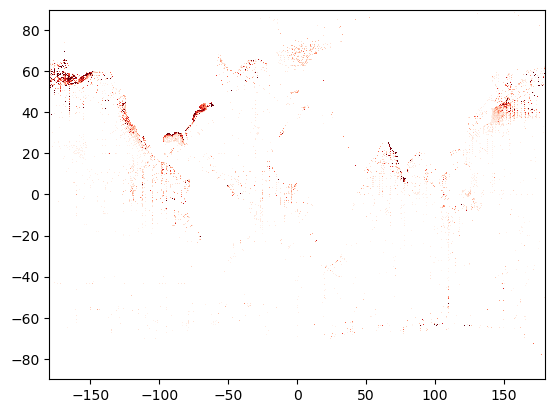

In [21]:
### add some more labels to this plot, or another version of it to show both quick and detailed

#ds_copepod['copepod_C'].plot()

plt.pcolormesh(ds_copepod.lon, ds_copepod.lat, ds_copepod.copepod_C, cmap='Reds', vmin=0, vmax=2)

# Make the chlorophyll and copepod maps

In [22]:
ds_grid_x1 = pop_tools.get_grid('POP_gx1v7')
lons_x1=ds_grid_x1.TLONG
lats_x1=ds_grid_x1.TLAT

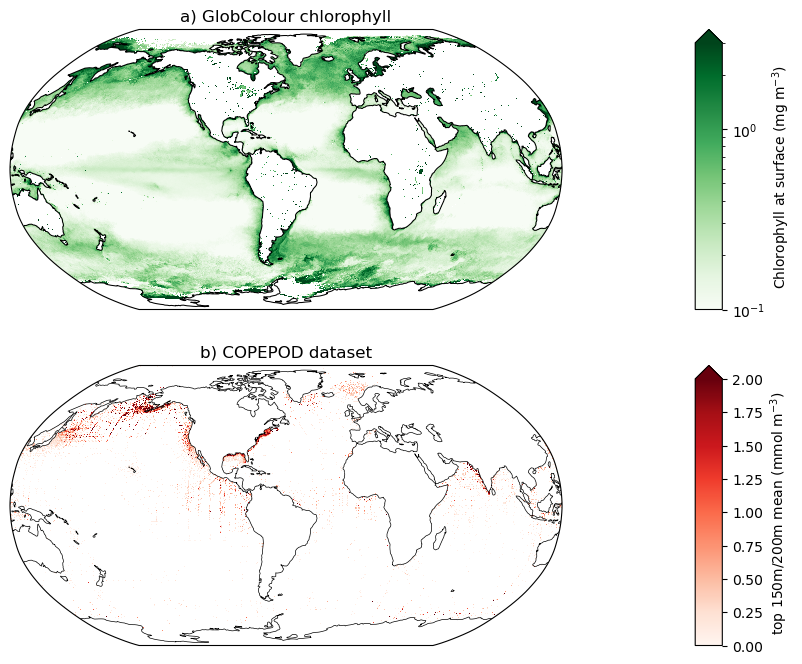

In [26]:
fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(nrows=2, ncols=2, width_ratios=(1, 0.04))

prj = ccrs.Robinson(central_longitude=305.0)

ax_chl_sat = plt.subplot(gs[0, 0], projection=prj)
ax_meso_cope = plt.subplot(gs[1, 0], projection=prj)

ax_chl_sat.set_title('a) GlobColour chlorophyll', fontsize=12)
pc_chl_sat=ax_chl_sat.pcolormesh(ds_sat.longitude, ds_sat.latitude, ds_sat.CHL, 
                     cmap='Greens',norm=colors.LogNorm(vmin=0.1, vmax=3),
                     transform=ccrs.PlateCarree())
ax_chl_sat.coastlines('110m',linewidth=0.75)


ax_meso_cope.set_title('b) COPEPOD dataset', fontsize=12)
pc_meso_cope=ax_meso_cope.pcolormesh(ds_copepod.lon, ds_copepod.lat, ds_copepod.copepod_C, cmap='Reds',vmin=0,vmax=2,transform=ccrs.PlateCarree())
ax_meso_cope.coastlines('110m',linewidth=0.5)


cax_chl = plt.subplot(gs[0, 1])
cax_meso = plt.subplot(gs[1, 1])

cb_chl = plt.colorbar(pc_chl_sat, cax=cax_chl,extend='max', 
                      label='Chlorophyll at surface (mg m$^{-3}$)')
cb_meso = plt.colorbar(pc_meso_cope, cax=cax_meso,extend='max', label='top 150m/200m mean (mmol m$^{-3}$)')


### why is land getting a nonzero value? fix through mask or otherwise

#fig.savefig('/glade/work/kristenk/figs/chl_copepod_comparison_x1.png', bbox_inches='tight', dpi=300, format='png');

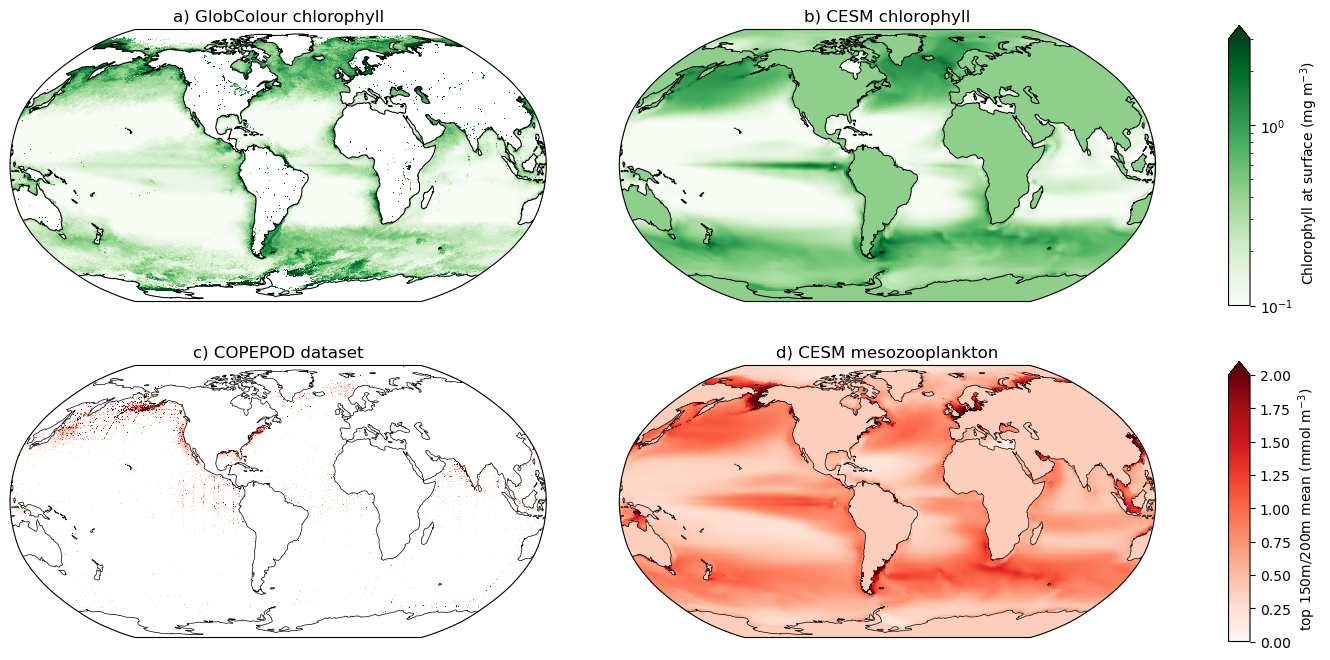

In [23]:
fig = plt.figure(figsize=(16, 8))
gs = gridspec.GridSpec(nrows=2, ncols=3, width_ratios=(1, 1, 0.04))

prj = ccrs.Robinson(central_longitude=305.0)

ax_chl_sat = plt.subplot(gs[0, 0], projection=prj)
ax_chl_cesm = plt.subplot(gs[0, 1], projection=prj)
ax_meso_cope = plt.subplot(gs[1, 0], projection=prj)
ax_meso_cesm = plt.subplot(gs[1, 1], projection=prj)

ax_chl_sat.set_title('a) GlobColour chlorophyll', fontsize=12)
pc_chl_sat=ax_chl_sat.pcolormesh(ds_sat.longitude, ds_sat.latitude, ds_sat.CHL, 
                     cmap='Greens',norm=colors.LogNorm(vmin=0.1, vmax=3),
                     transform=ccrs.PlateCarree())
ax_chl_sat.coastlines('110m',linewidth=0.75)

ax_chl_cesm.set_title('b) CESM chlorophyll', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  cesm_chl)
ax_chl_cesm.coastlines('110m',linewidth=0.75)
pc_chl_cesm=ax_chl_cesm.pcolormesh(lon, lat, field, cmap='Greens',
                 norm=colors.LogNorm(vmin=0.1, vmax=3),transform=ccrs.PlateCarree())




ax_meso_cope.set_title('c) COPEPOD dataset', fontsize=12)
pc_meso_cope=ax_meso_cope.pcolormesh(ds_copepod.lon, ds_copepod.lat, ds_copepod.copepod_C, cmap='Reds',vmin=0,vmax=2,transform=ccrs.PlateCarree())
ax_meso_cope.coastlines('110m',linewidth=0.5)

ax_meso_cesm.set_title('d) CESM mesozooplankton', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds.mesozooC)
pc_meso_cesm=ax_meso_cesm.pcolormesh(lon, lat, field, cmap='Reds',vmin=0,vmax=2,transform=ccrs.PlateCarree())
ax_meso_cesm.coastlines('110m',linewidth=0.5)

cax_chl = plt.subplot(gs[0, 2])
cax_meso = plt.subplot(gs[1, 2])

cb_chl = plt.colorbar(pc_chl_cesm, cax=cax_chl,extend='max', 
                      label='Chlorophyll at surface (mg m$^{-3}$)')
cb_meso = plt.colorbar(pc_meso_cesm, cax=cax_meso,extend='max', label='top 150m/200m mean (mmol m$^{-3}$)')


### why is land getting a nonzero value? fix through mask or otherwise

#fig.savefig('/glade/work/kristenk/figs/chl_copepod_comparison_x1.png', bbox_inches='tight', dpi=300, format='png');

In [24]:
cluster.close()